# XGBoost Pipeline with Manual Feature Extraction

**Purpose**: Create a machine learning pipeline using XGBoost with manual feature extraction using the tifex library.

**Pipeline Steps**:
1. Load configuration and setup
2. Load pre-processed windowed data directly
3. Extract specific features using tifex
4. Train XGBoost model
5. Evaluate performance

**Key Features**:
- Direct loading of pre-processed windowed data
- Manual feature selection using tifex library
- XGBoost classifier implementation
- Streamlined pipeline for faster execution

## 1. Configuration and Setup

In [51]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import yaml
import pickle
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Import tifex for feature extraction - using direct calculators
import tifex_py.feature_extraction.statistical_feature_calculators as stat_calc
import tifex_py.feature_extraction.spectral_feature_calculators as spec_calc
import tifex_py.feature_extraction.time_frequency_feature_calculators as tf_calc
from scipy import signal
import pywt

# Configuration
PROJECT_ROOT = '/scai_data3/scratch/stirnimann_r'
CONFIG_PATH = os.path.join(PROJECT_ROOT, 'config.yaml')

print(f"📋 XGBoost Pipeline with Manual Feature Extraction")
print(f"  Project root: {PROJECT_ROOT}")
print(f"  Config file: {CONFIG_PATH}")

# Load configuration
print(f"\n=== LOADING CONFIGURATION ===")
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

# Extract relevant parameters  
WINDOW_SIZE = config.get('window_size', 125)  # Default 5s at 25Hz
WINDOW_STEP = config.get('window_step', 25)   # Default 1s at 25Hz
TARGET_COLUMN = config.get('target_column', 'Activity')
RESULTS_DIR = os.path.join(PROJECT_ROOT, config.get('results_dir', 'results'))
ACTIVITIES_OF_INTEREST = config.get('ACTIVITIES_OF_INTEREST', None)

# Define path to pre-processed windowed data
WINDOWED_DATA_PATH = '/scai_data3/scratch/stirnimann_r/results/pipeline/combined_windowed_dataset_mapped_filtered.pkl'

print(f"✅ Configuration loaded successfully!")
print(f"  Window size: {WINDOW_SIZE} samples")
print(f"  Window step: {WINDOW_STEP} samples")
print(f"  Target column: {TARGET_COLUMN}")
if ACTIVITIES_OF_INTEREST:
    print(f"  Activities of interest: {ACTIVITIES_OF_INTEREST}")
print(f"  Windowed data path: {WINDOWED_DATA_PATH}")

# Calculate window parameters
SAMPLING_FREQ = 25  # Hz (from config)
WINDOW_DURATION_SEC = WINDOW_SIZE / SAMPLING_FREQ
STEP_DURATION_SEC = WINDOW_STEP / SAMPLING_FREQ

print(f"\n📊 Window Parameters:")
print(f"  Window duration: {WINDOW_DURATION_SEC:.1f} seconds")
print(f"  Step duration: {STEP_DURATION_SEC:.1f} seconds")
print(f"  Overlap: {((WINDOW_SIZE - WINDOW_STEP) / WINDOW_SIZE * 100):.1f}%")

# Create output directory for pipeline results
PIPELINE_RESULTS_DIR = os.path.join(RESULTS_DIR, 'xgboost_pipeline')
os.makedirs(PIPELINE_RESULTS_DIR, exist_ok=True)
print(f"  Pipeline output: {PIPELINE_RESULTS_DIR}")

# Helper function to load saved features and labels
def load_saved_features_and_labels(pipeline_results_dir):
    """
    Load previously saved features and labels for reuse
    
    Parameters:
    - pipeline_results_dir: Path to the pipeline results directory
    
    Returns:
    - Dictionary containing loaded data
    """
    data_path = os.path.join(pipeline_results_dir, 'feature_matrix_and_labels.pkl')
    
    if not os.path.exists(data_path):
        print(f"❌ Saved data file not found: {data_path}")
        return None
    
    try:
        with open(data_path, 'rb') as f:
            saved_data = pickle.load(f)
        
        print(f"✅ Loaded saved features and labels:")
        print(f"  Feature matrix shape: {saved_data['X'].shape}")
        print(f"  Labels shape: {saved_data['y'].shape}")
        print(f"  Number of features: {len(saved_data['feature_names'])}")
        print(f"  Number of classes: {len(saved_data['label_encoder_classes'])}")
        if 'extraction_config' in saved_data:
            print(f"  Extraction date: {saved_data['extraction_config']['extraction_timestamp']}")
        
        return saved_data
        
    except Exception as e:
        print(f"❌ Error loading saved data: {str(e)}")
        return None

print(f"📋 Helper function 'load_saved_features_and_labels()' available for reuse")

📋 XGBoost Pipeline with Manual Feature Extraction
  Project root: /scai_data3/scratch/stirnimann_r
  Config file: /scai_data3/scratch/stirnimann_r/config.yaml

=== LOADING CONFIGURATION ===
✅ Configuration loaded successfully!
  Window size: 250 samples
  Window step: 225 samples
  Target column: Label
  Activities of interest: ['Arm Raises', 'Self Propulsion', 'Eating', 'Resting', 'Assisted Propulsion', 'Transfer', 'Conversation', 'Changing Clothes']
  Windowed data path: /scai_data3/scratch/stirnimann_r/results/pipeline/combined_windowed_dataset_mapped_filtered.pkl

📊 Window Parameters:
  Window duration: 10.0 seconds
  Step duration: 9.0 seconds
  Overlap: 10.0%
  Pipeline output: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline
📋 Helper function 'load_saved_features_and_labels()' available for reuse


## 2. Load Pre-processed Windowed Data

In [52]:
# Load the pre-processed windowed data directly
print(f"\n=== LOADING PRE-PROCESSED WINDOWED DATA ===")

if not os.path.exists(WINDOWED_DATA_PATH):
    print(f"❌ Windowed data file not found: {WINDOWED_DATA_PATH}")
    print(f"💡 Please ensure the windowed data has been generated from the main pipeline")
    combined_windows = None
    combined_labels = None
    combined_window_info = None
else:
    print(f"📊 Loading windowed data from: {WINDOWED_DATA_PATH}")
    
    try:
        with open(WINDOWED_DATA_PATH, 'rb') as f:
            windowed_data = pickle.load(f)
        
        # Extract data components
        combined_windows = windowed_data['windows']
        combined_labels = windowed_data['labels']
        combined_window_info = windowed_data['window_info']
        
        print(f"✅ Windowed data loaded successfully!")
        
        print(f"  Total windows: {combined_windows.shape[0]}")
        print(f"  Window size: {combined_windows.shape[1]} samples")
        print(f"  Features per window: {combined_windows.shape[2]}")
        print(f"  Labels shape: {combined_labels.shape}")
        
        # Display label distribution
        print(f"\n📊 Label Distribution:")
        label_counts = pd.Series(combined_labels).value_counts()
        for label, count in label_counts.items():
            percentage = count / len(combined_labels) * 100
            print(f"  {label}: {count} windows ({percentage:.1f}%)")
        
        # Display subject distribution if available
        if 'subject_id' in combined_window_info.columns:
            print(f"\n📊 Subject Distribution:")
            subject_counts = combined_window_info['subject_id'].value_counts()
            for subject, count in subject_counts.items():
                percentage = count / len(combined_window_info) * 100
                print(f"  {subject}: {count} windows ({percentage:.1f}%)")
        
        # Get sensor column names - use the actual sensor names from REQUIRED_SENSOR_COLUMNS
        if 'sensor_config' in windowed_data and 'final_sensor_columns' in windowed_data['sensor_config']:
            sensor_columns = windowed_data['sensor_config']['final_sensor_columns']
            print(f"\n📊 Sensor Information:")
            print(f"  Available sensor columns: {len(sensor_columns)}")
            print(f"  Sensor columns loaded from windowed data:")
            for i, sensor in enumerate(sensor_columns[:5]):
                print(f"    {i+1}. {sensor}")
            if len(sensor_columns) > 5:
                print(f"    ... and {len(sensor_columns) - 5} more")
        else:
            # Fallback to REQUIRED_SENSOR_COLUMNS if not found in windowed data
            print(f"\n⚠️ Sensor column names not found in windowed data, using REQUIRED_SENSOR_COLUMNS")
            sensor_columns = REQUIRED_SENSOR_COLUMNS[:combined_windows.shape[2]]  # Trim to match actual data
            print(f"  Using {len(sensor_columns)} sensor columns from REQUIRED_SENSOR_COLUMNS")
        
        # Verify sensor columns match data dimensions
        if len(sensor_columns) != combined_windows.shape[2]:
            print(f"⚠️ WARNING: Sensor column count mismatch!")
            print(f"  Expected: {combined_windows.shape[2]} columns")
            print(f"  Found: {len(sensor_columns)} sensor names")
            
            # Adjust sensor_columns to match data dimensions
            if len(sensor_columns) > combined_windows.shape[2]:
                sensor_columns = sensor_columns[:combined_windows.shape[2]]
                print(f"  Trimmed sensor columns to match data: {len(sensor_columns)}")
            elif len(sensor_columns) < combined_windows.shape[2]:
                # Pad with generic names if needed
                for i in range(len(sensor_columns), combined_windows.shape[2]):
                    sensor_columns.append(f'sensor_{i}')
                print(f"  Added generic sensor names for missing columns: {len(sensor_columns)}")
        
        # Verify no NaN values in the windowed data
        nan_count = np.isnan(combined_windows).sum()
        if nan_count > 0:
            print(f"  ⚠️ WARNING: Found {nan_count} NaN values in windowed data")
        else:
            print(f"  ✅ No NaN values found in windowed data")
        
        # Display the actual sensor names being used
        print(f"\n📊 Final sensor columns ({len(sensor_columns)}):")
        for i, sensor in enumerate(sensor_columns):
            print(f"  {i+1:2d}. {sensor}")
        
    except Exception as e:
        print(f"❌ Error loading windowed data: {str(e)}")
        combined_windows = None
        combined_labels = None
        combined_window_info = None
        sensor_columns = None

# Check if data was loaded successfully
if combined_windows is not None:
    print(f"\n✅ Data loading completed successfully!")
    print(f"  Ready for feature extraction with actual sensor names...")
else:
    print(f"\n❌ Data loading failed!")
    print(f"  Cannot proceed with feature extraction")


=== LOADING PRE-PROCESSED WINDOWED DATA ===
📊 Loading windowed data from: /scai_data3/scratch/stirnimann_r/results/pipeline/combined_windowed_dataset_mapped_filtered.pkl
✅ Windowed data loaded successfully!
  Total windows: 15604
  Window size: 250 samples
  Features per window: 26
  Labels shape: (15604,)

📊 Label Distribution:
  Conversation: 7700 windows (49.3%)
  Resting: 3542 windows (22.7%)
  Self Propulsion: 2809 windows (18.0%)
  Eating: 835 windows (5.4%)
  Assisted Propulsion: 339 windows (2.2%)
  Transfer: 189 windows (1.2%)
  Changing Clothes: 164 windows (1.1%)
  Arm Raises: 26 windows (0.2%)

📊 Sensor Information:
  Available sensor columns: 26
  Sensor columns loaded from windowed data:
    1. corsano_wrist_wrist_acc_x
    2. corsano_wrist_wrist_acc_y
    3. corsano_wrist_wrist_acc_z
    4. mbient_acc_x_axis_g
    5. mbient_acc_y_axis_g
    ... and 21 more
  ✅ No NaN values found in windowed data

📊 Final sensor columns (26):
   1. corsano_wrist_wrist_acc_x
   2. corsan

## 3. Feature Extraction using Tifex

Now we'll extract specific features from each window using the tifex library. We'll focus on the requested features that provide comprehensive statistical, spectral, and time-frequency information.

In [53]:
# Define the specific features to extract based on the request

REQUESTED_FEATURES = [
    'mean_of_auto_corr_lag_1_to_23',
    'higuchi_fractal_dimensions_k=10',
    'mean',
    'no._of_slope_sign_changes',
    'shape_factor',
    'moment_order_3',
    'spectrum_linear_slope',
    'higuchi_fractal_dimensions_k=20',
    'hjorth_complexity',
    'higuchi_fractal_dimensions_k=5',
    'min',
    'max_of_tkeo',
    'iqr_of_wav_coeffs_lvl_4',
    'no._of_mean_crossings_of_tkeo',
    'no._of_zero_crossings',
    'harmonic_mean_of_abs',
    'min_of_abs',
    'geometric_mean',
    'max',
    'max_of_wav_coeffs_lvl_0',
    'geometric_mean_of_abs',
    'coefficient_of_variation_of_tkeo',
    'min_of_wav_coeffs_lvl_0',
    'svd_entropy',
    'no._of_mean_crossings',
    'rms',
    'no._of_zero_crossings_of_tkeo',
    'hjorth_mobility',
    'permutation_entropy',
    'entropy',
    'no._of_slope_sign_changes_of_tkeo',
    'coefficient_of_variation',
    'spectral_rel_power_band_[0.6, 4]',
    'median',
    'max_of_abs',
    'trimmed_mean_thresh_0.1',
    'higuchi_fractal_dimensions_k=40',
    'max_of_wav_coeffs_lvl_4',
    'skewness',
    'median_of_wav_coeffs_lvl_0',
    'skewness_of_abs',
    'iqr',
    'skewness_of_tkeo',
    'median_of_abs',
    'median_abs_deviation',
    'kurtosis',
    'std_of_abs',
    'kurtosis_of_wav_coeffs_4',
    'skewness_of_wav_coeffs_4',
    'min_of_wav_coeffs_lvl_4'
]

print(f"📊 Feature Extraction Configuration:")
print(f"  Requested features: {len(REQUESTED_FEATURES)}")
print(f"  Features include: statistical, spectral, and time-frequency features")

# Check if feature extraction output already exists
print(f"\n🔍 Checking if feature extraction output already exists...")
saved_features_data = load_saved_features_and_labels(PIPELINE_RESULTS_DIR)

if saved_features_data is not None:
    print(f"✅ Found existing feature extraction output!")
    print(f"  Loading pre-computed features and labels...")
    
    # Load the saved data
    X = saved_features_data['X']
    y = saved_features_data['y']
    feature_names = saved_features_data['feature_names']
    combined_labels = saved_features_data['original_labels']
    
    # Check if window_info is available
    if 'window_info' in saved_features_data:
        combined_window_info = saved_features_data['window_info']
        print(f"  Window info loaded successfully")
    else:
        print(f"  ⚠️ Window info not found in saved data")
        combined_window_info = None
    
    # Display extraction config if available
    if 'extraction_config' in saved_features_data:
        config = saved_features_data['extraction_config']
        print(f"  Extraction configuration:")
        print(f"    Window size: {config.get('window_size', 'N/A')}")
        print(f"    Window step: {config.get('window_step', 'N/A')}")
        print(f"    Sampling freq: {config.get('sampling_freq', 'N/A')}")
        print(f"    Extraction date: {config.get('extraction_timestamp', 'N/A')}")
    
    print(f"\n📊 Loaded feature data summary:")
    print(f"  Feature matrix shape: {X.shape}")
    print(f"  Labels shape: {y.shape}")
    print(f"  Number of features: {len(feature_names)}")
    print(f"  Number of classes: {len(set(y))}")
    
    # Display label distribution
    print(f"\n📊 Label Distribution:")
    label_counts = pd.Series(y).value_counts()
    for label, count in label_counts.items():
        percentage = count / len(y) * 100
        print(f"  {label}: {count} samples ({percentage:.1f}%)")
    
    print(f"\n✅ Feature extraction skipped - using pre-computed features!")
    print(f"  Ready to proceed with model training...")
    
else:
    print(f"❌ No existing feature extraction output found")
    print(f"  Will proceed with feature extraction...")
    
    # Feature extraction will use direct calculators for each window
    print(f"\n🔧 Setting up direct feature calculators...")
    print(f"✅ Direct feature calculators ready")
    print(f"  Statistical features: mean, std, skewness, kurtosis, min, max, median, etc.")
    print(f"  Spectral features: power spectral density, frequency bands, etc.")
    print(f"  Time-frequency features: wavelet coefficients, TKEO, Hjorth parameters, etc.")
    print(f"  All features will be calculated directly using tifex library functions")
    
    print(f"  Ready to extract {len(REQUESTED_FEATURES)} requested features")

📊 Feature Extraction Configuration:
  Requested features: 50
  Features include: statistical, spectral, and time-frequency features

🔍 Checking if feature extraction output already exists...


✅ Loaded saved features and labels:
  Feature matrix shape: (18358, 1196)
  Labels shape: (18358,)
  Number of features: 1196
  Number of classes: 12
  Extraction date: 2025-07-16T20:42:36.771121
✅ Found existing feature extraction output!
  Loading pre-computed features and labels...
  Window info loaded successfully
  Extraction configuration:
    Window size: 250
    Window step: 225
    Sampling freq: 25
    Extraction date: 2025-07-16T20:42:36.771121

📊 Loaded feature data summary:
  Feature matrix shape: (18358, 1196)
  Labels shape: (18358,)
  Number of features: 1196
  Number of classes: 12

📊 Label Distribution:
  Conversation: 7700 samples (41.9%)
  Resting: 3542 samples (19.3%)
  Self Propulsion: 2809 samples (15.3%)
  Using Computer: 1663 samples (9.1%)
  Using Phone: 962 samples (5.2%)
  Eating: 835 samples (4.5%)
  Assisted Propulsion: 339 samples (1.8%)
  Transfer: 189 samples (1.0%)
  Changing Clothes: 164 samples (0.9%)
  Washing Hands: 95 samples (0.5%)
  Pressure Rel

In [54]:
# Only proceed with feature extraction if we don't have pre-computed features
if 'X' not in locals() or X is None:
    print(f"\n=== STARTING FEATURE EXTRACTION ===")
    
    def extract_features_from_single_window(window_data, sensor_columns):
        """
        Extract features from a single window using direct feature calculators
        
        Parameters:
        - window_data: 2D array (window_size, n_features)
        - sensor_columns: List of sensor column names
        
        Returns:
        - features_dict: Dictionary with extracted features
        """
        
        features = {}
        
        # Convert window to DataFrame for easier handling
        window_df = pd.DataFrame(window_data, columns=sensor_columns)
        
        # Extract features for each sensor column
        for col in sensor_columns:
            series = window_df[col].values
            
            # Skip if all values are NaN
            if np.all(np.isnan(series)):
                continue
                
            # Handle NaN values by interpolation
            if np.any(np.isnan(series)):
                series = pd.Series(series).interpolate().fillna(method='bfill').fillna(method='ffill').values
            
            # Extract basic statistical features
            try:
                # Basic statistical features
                if 'mean' in REQUESTED_FEATURES:
                    features[f'{col}_mean'] = stat_calc.calculate_mean(series)
                if 'min' in REQUESTED_FEATURES:
                    features[f'{col}_min'] = stat_calc.calculate_min(series)
                if 'max' in REQUESTED_FEATURES:
                    features[f'{col}_max'] = stat_calc.calculate_max(series)
                if 'median' in REQUESTED_FEATURES:
                    features[f'{col}_median'] = stat_calc.calculate_median(series)
                if 'std' in REQUESTED_FEATURES:
                    features[f'{col}_std'] = stat_calc.calculate_std(series)
                if 'var' in REQUESTED_FEATURES:
                    features[f'{col}_var'] = stat_calc.calculate_variance(series)
                if 'skewness' in REQUESTED_FEATURES:
                    features[f'{col}_skewness'] = stat_calc.calculate_skewness(series)
                if 'kurtosis' in REQUESTED_FEATURES:
                    features[f'{col}_kurtosis'] = stat_calc.calculate_kurtosis(series)
                if 'iqr' in REQUESTED_FEATURES:
                    features[f'{col}_iqr'] = stat_calc.calculate_interquartile_range(series)
                if 'rms' in REQUESTED_FEATURES:
                    features[f'{col}_rms'] = stat_calc.calculate_root_mean_square(series)
                if 'geometric_mean' in REQUESTED_FEATURES:
                    features[f'{col}_geometric_mean'] = stat_calc.calculate_geometric_mean(np.abs(series))
                if 'harmonic_mean_of_abs' in REQUESTED_FEATURES:
                    features[f'{col}_harmonic_mean_of_abs'] = stat_calc.calculate_harmonic_mean_abs(series)
                if 'coefficient_of_variation' in REQUESTED_FEATURES:
                    features[f'{col}_coefficient_of_variation'] = stat_calc.calculate_coefficient_of_variation(series)
                if 'median_abs_deviation' in REQUESTED_FEATURES:
                    features[f'{col}_median_abs_deviation'] = stat_calc.calculate_median_absolute_deviation(series, adjusted=False)
                if 'shape_factor' in REQUESTED_FEATURES:
                    features[f'{col}_shape_factor'] = stat_calc.calculate_shape_factor(series)
                if 'moment_order_3' in REQUESTED_FEATURES:
                    features[f'{col}_moment_order_3'] = stat_calc.calculate_higher_order_moments(series, [3])[0]
                
                # Absolute value features
                if 'min_of_abs' in REQUESTED_FEATURES:
                    features[f'{col}_min_of_abs'] = stat_calc.calculate_min_abs(series)
                if 'max_of_abs' in REQUESTED_FEATURES:
                    features[f'{col}_max_of_abs'] = stat_calc.calculate_max_abs(series)
                if 'median_of_abs' in REQUESTED_FEATURES:
                    features[f'{col}_median_of_abs'] = stat_calc.calculate_median_abs(series)
                if 'std_of_abs' in REQUESTED_FEATURES:
                    features[f'{col}_std_of_abs'] = stat_calc.calculate_std_abs(series)
                if 'skewness_of_abs' in REQUESTED_FEATURES:
                    features[f'{col}_skewness_of_abs'] = stat_calc.calculate_skewness_abs(series)
                if 'geometric_mean_of_abs' in REQUESTED_FEATURES:
                    features[f'{col}_geometric_mean_of_abs'] = stat_calc.calculate_geometric_mean_abs(series)
                
                # Crossing features
                if 'no._of_zero_crossings' in REQUESTED_FEATURES:
                    features[f'{col}_no_of_zero_crossings'] = stat_calc.calculate_zero_crossings(series)
                if 'no._of_mean_crossings' in REQUESTED_FEATURES:
                    features[f'{col}_no_of_mean_crossings'] = stat_calc.calculate_mean_crossing(series)
                if 'no._of_slope_sign_changes' in REQUESTED_FEATURES:
                    features[f'{col}_no_of_slope_sign_changes'] = stat_calc.calculate_slope_sign_change(series, ssc_threshold=0)
                
                # Trimmed mean
                if 'trimmed_mean_thresh_0.1' in REQUESTED_FEATURES:
                    features[f'{col}_trimmed_mean_thresh_0.1'] = stat_calc.calculate_trimmed_mean(series, [0.1])[0]
                
                # Auto-correlation
                if 'mean_of_auto_corr_lag_1_to_23' in REQUESTED_FEATURES:
                    features[f'{col}_mean_of_auto_corr_lag_1_to_23'] = stat_calc.calculate_mean_auto_correlation(series, n_lags_auto_correlation=23)
                
                # Time-frequency features
                if 'entropy' in REQUESTED_FEATURES:
                    features[f'{col}_entropy'] = stat_calc.calculate_entropy(series, window_size=len(series))
                if 'svd_entropy' in REQUESTED_FEATURES:
                    features[f'{col}_svd_entropy'] = stat_calc.calculate_svd_entropy(series, svd_entropy_order=3, svd_entropy_delay=1)
                if 'permutation_entropy' in REQUESTED_FEATURES:
                    features[f'{col}_permutation_entropy'] = stat_calc.calculate_permutation_entropy(series, window_size=len(series), permutation_entropy_order=3, permutation_entropy_delay=1)
                
                # Hjorth parameters
                if 'hjorth_mobility' in REQUESTED_FEATURES or 'hjorth_complexity' in REQUESTED_FEATURES:
                    hjorth_values = stat_calc.calculate_hjorth_mobility_and_complexity(series)
                    if 'hjorth_mobility' in REQUESTED_FEATURES:
                        features[f'{col}_hjorth_mobility'] = hjorth_values[0]
                    if 'hjorth_complexity' in REQUESTED_FEATURES:
                        features[f'{col}_hjorth_complexity'] = hjorth_values[1]
                
                # Higuchi fractal dimensions
                if any(f'higuchi_fractal_dimensions_k={k}' in REQUESTED_FEATURES for k in [5, 10, 20, 40]):
                    k_values = []
                    if 'higuchi_fractal_dimensions_k=5' in REQUESTED_FEATURES:
                        k_values.append(5)
                    if 'higuchi_fractal_dimensions_k=10' in REQUESTED_FEATURES:
                        k_values.append(10)
                    if 'higuchi_fractal_dimensions_k=20' in REQUESTED_FEATURES:
                        k_values.append(20)
                    if 'higuchi_fractal_dimensions_k=40' in REQUESTED_FEATURES:
                        k_values.append(40)
                    
                    if k_values:
                        hfd_values = stat_calc.calculate_higuchi_fractal_dimensions(series, k_values)
                        for i, k in enumerate(k_values):
                            features[f'{col}_higuchi_fractal_dimensions_k={k}'] = hfd_values[i]
                
                # TKEO-based features
                try:
                    # Calculate TKEO using the teager_kaiser_energy_operator function
                    tkeo_signal = np.zeros_like(series)
                    if len(series) > 2:
                        tkeo_signal[1:-1] = series[1:-1]**2 - series[:-2] * series[2:]
                    
                    if 'max_of_tkeo' in REQUESTED_FEATURES:
                        features[f'{col}_max_of_tkeo'] = stat_calc.calculate_max(tkeo_signal)
                    if 'no._of_mean_crossings_of_tkeo' in REQUESTED_FEATURES:
                        features[f'{col}_no_of_mean_crossings_of_tkeo'] = stat_calc.calculate_mean_crossing(tkeo_signal)
                    if 'no._of_zero_crossings_of_tkeo' in REQUESTED_FEATURES:
                        features[f'{col}_no_of_zero_crossings_of_tkeo'] = stat_calc.calculate_zero_crossings(tkeo_signal)
                    if 'coefficient_of_variation_of_tkeo' in REQUESTED_FEATURES:
                        features[f'{col}_coefficient_of_variation_of_tkeo'] = stat_calc.calculate_coefficient_of_variation(tkeo_signal)
                    if 'no._of_slope_sign_changes_of_tkeo' in REQUESTED_FEATURES:
                        features[f'{col}_no_of_slope_sign_changes_of_tkeo'] = stat_calc.calculate_slope_sign_change(tkeo_signal, ssc_threshold=0)
                    if 'skewness_of_tkeo' in REQUESTED_FEATURES:
                        features[f'{col}_skewness_of_tkeo'] = stat_calc.calculate_skewness(tkeo_signal)
                except:
                    pass  # Skip TKEO features if calculation fails
                
                # Wavelet-based features
                try:
                    # Wavelet decomposition
                    wavelet_coeffs = pywt.wavedec(series, 'db4', level=4)
                    
                    # Level 0 (approximation coefficients)
                    if len(wavelet_coeffs) > 0:
                        level_0_coeffs = wavelet_coeffs[0]
                        if 'max_of_wav_coeffs_lvl_0' in REQUESTED_FEATURES:
                            features[f'{col}_max_of_wav_coeffs_lvl_0'] = stat_calc.calculate_max(level_0_coeffs)
                        if 'min_of_wav_coeffs_lvl_0' in REQUESTED_FEATURES:
                            features[f'{col}_min_of_wav_coeffs_lvl_0'] = stat_calc.calculate_min(level_0_coeffs)
                        if 'median_of_wav_coeffs_lvl_0' in REQUESTED_FEATURES:
                            features[f'{col}_median_of_wav_coeffs_lvl_0'] = stat_calc.calculate_median(level_0_coeffs)
                    
                    # Level 4 (detail coefficients) - note: index 4 means the 4th detail coefficient
                    if len(wavelet_coeffs) > 4:
                        level_4_coeffs = wavelet_coeffs[4]
                        if 'max_of_wav_coeffs_lvl_4' in REQUESTED_FEATURES:
                            features[f'{col}_max_of_wav_coeffs_lvl_4'] = stat_calc.calculate_max(level_4_coeffs)
                        if 'min_of_wav_coeffs_lvl_4' in REQUESTED_FEATURES:
                            features[f'{col}_min_of_wav_coeffs_lvl_4'] = stat_calc.calculate_min(level_4_coeffs)
                        if 'iqr_of_wav_coeffs_lvl_4' in REQUESTED_FEATURES:
                            features[f'{col}_iqr_of_wav_coeffs_lvl_4'] = stat_calc.calculate_interquartile_range(level_4_coeffs)
                        if 'kurtosis_of_wav_coeffs_4' in REQUESTED_FEATURES:
                            features[f'{col}_kurtosis_of_wav_coeffs_4'] = stat_calc.calculate_kurtosis(level_4_coeffs)
                        if 'skewness_of_wav_coeffs_4' in REQUESTED_FEATURES:
                            features[f'{col}_skewness_of_wav_coeffs_4'] = stat_calc.calculate_skewness(level_4_coeffs)
                    elif len(wavelet_coeffs) > 1:
                        # If we don't have level 4, use the last available level
                        level_4_coeffs = wavelet_coeffs[-1]
                        if 'max_of_wav_coeffs_lvl_4' in REQUESTED_FEATURES:
                            features[f'{col}_max_of_wav_coeffs_lvl_4'] = stat_calc.calculate_max(level_4_coeffs)
                        if 'min_of_wav_coeffs_lvl_4' in REQUESTED_FEATURES:
                            features[f'{col}_min_of_wav_coeffs_lvl_4'] = stat_calc.calculate_min(level_4_coeffs)
                        if 'iqr_of_wav_coeffs_lvl_4' in REQUESTED_FEATURES:
                            features[f'{col}_iqr_of_wav_coeffs_lvl_4'] = stat_calc.calculate_interquartile_range(level_4_coeffs)
                        if 'kurtosis_of_wav_coeffs_4' in REQUESTED_FEATURES:
                            features[f'{col}_kurtosis_of_wav_coeffs_4'] = stat_calc.calculate_kurtosis(level_4_coeffs)
                        if 'skewness_of_wav_coeffs_4' in REQUESTED_FEATURES:
                            features[f'{col}_skewness_of_wav_coeffs_4'] = stat_calc.calculate_skewness(level_4_coeffs)
                except:
                    pass  # Skip wavelet features if calculation fails
                
                # Spectral features
                try:
                    # Power spectral density
                    freqs, psd = signal.periodogram(series, fs=SAMPLING_FREQ)
                    
                    if 'spectrum_linear_slope' in REQUESTED_FEATURES:
                        # Linear slope of power spectrum
                        log_psd = np.log10(psd + 1e-12)  # Add small value to avoid log(0)
                        slope = np.polyfit(freqs, log_psd, 1)[0]
                        features[f'{col}_spectrum_linear_slope'] = slope
                    
                    if 'spectral_rel_power_band_[0.6, 4]' in REQUESTED_FEATURES:
                        # Relative power in frequency band [0.6, 4] Hz
                        band_mask = (freqs >= 0.6) & (freqs <= 4.0)
                        band_power = np.sum(psd[band_mask])
                        total_power = np.sum(psd)
                        features[f'{col}_spectral_rel_power_band_[0.6, 4]'] = band_power / total_power if total_power > 0 else 0
                except:
                    pass  # Skip spectral features if calculation fails
                    
            except Exception as e:
                # If any feature calculation fails, skip this sensor
                print(f"    ⚠️ Error calculating features for {col}: {str(e)}")
                continue
        
        return features

    def extract_features_from_windows(windows, sensor_columns, batch_size=100):
        """
        Extract features from all windows using direct feature calculators
        
        Parameters:
        - windows: 3D array (n_windows, window_size, n_features)
        - sensor_columns: List of sensor column names
        - batch_size: Number of windows to process at once
        
        Returns:
        - features_df: DataFrame with extracted features for each window
        """
        
        n_windows, window_size, n_sensors = windows.shape
        print(f"🔄 Extracting features from {n_windows} windows...")
        print(f"  Window size: {window_size} samples")
        print(f"  Sensors: {n_sensors}")
        print(f"  Batch size: {batch_size}")
        print(f"  Using direct feature calculators")
        
        all_features = []
        
        # Process windows in batches to manage memory
        for batch_start in range(0, n_windows, batch_size):
            batch_end = min(batch_start + batch_size, n_windows)
            batch_windows = windows[batch_start:batch_end]
            
            print(f"  Processing batch {batch_start//batch_size + 1}/{(n_windows-1)//batch_size + 1} (windows {batch_start} to {batch_end-1})")
            
            batch_features = []
            
            # Process each window in the batch
            for i, window in enumerate(batch_windows):
                try:
                    # Extract features for this window
                    window_features = extract_features_from_single_window(window, sensor_columns)
                    batch_features.append(window_features)
                    
                except Exception as e:
                    print(f"    ⚠️ Error processing window {batch_start + i}: {str(e)}")
                    # Create empty feature dict for failed windows
                    window_features = {}
                    batch_features.append(window_features)
            
            all_features.extend(batch_features)
            
            if (batch_start // batch_size + 1) % 5 == 0:  # Progress update every 5 batches
                print(f"    ✅ Processed {batch_end} / {n_windows} windows")
        
        print(f"✅ Feature extraction completed!")
        
        # Convert to DataFrame
        features_df = pd.DataFrame(all_features)
        print(f"  Features DataFrame shape: {features_df.shape}")
        print(f"  Total features extracted: {features_df.shape[1]}")
        
        return features_df

    # Check if we have windows to process
    if combined_windows is not None:
        print(f"Sensor columns: {len(sensor_columns)}")
        print(f"First few sensor columns: {sensor_columns[:5]}")
        
        # Extract features from all windows
        features_df = extract_features_from_windows(
            combined_windows, 
            sensor_columns,
            batch_size=50  # Smaller batch size to manage memory
        )
        
        print(f"\n📊 Feature extraction summary:")
        print(f"  Total windows processed: {len(features_df)}")
        print(f"  Total features per window: {features_df.shape[1]}")
        print(f"  Memory usage: {features_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
    else:
        print(f"❌ No windows available for feature extraction!")
        
else:
    print(f"\n✅ SKIPPING FEATURE EXTRACTION - Using pre-loaded features")
    print(f"  Feature matrix shape: {X.shape}")
    print(f"  Labels shape: {y.shape}")
    print(f"  Number of features: {len(feature_names)}")
    print(f"  Ready to proceed with model training!")


✅ SKIPPING FEATURE EXTRACTION - Using pre-loaded features
  Feature matrix shape: (18358, 1196)
  Labels shape: (18358,)
  Number of features: 1196
  Ready to proceed with model training!


In [55]:
# Feature filtering and preprocessing - only if we just extracted features
if 'features_df' in locals() and features_df is not None:
    print(f"\n=== FEATURE FILTERING AND PREPROCESSING ===")
    
    # Filter data based on ACTIVITIES_OF_INTEREST from config
    if ACTIVITIES_OF_INTEREST:
        print(f"\n🔄 Filtering data for activities of interest: {ACTIVITIES_OF_INTEREST}")
        
        # Create a boolean mask for labels to keep
        initial_count = len(combined_labels)
        mask = pd.Series(combined_labels).isin(ACTIVITIES_OF_INTEREST)
        
        # Apply the mask to features, labels, and window info
        features_df = features_df[mask].reset_index(drop=True)
        combined_labels = pd.Series(combined_labels)[mask].values
        if combined_window_info is not None:
            combined_window_info = combined_window_info[mask].reset_index(drop=True)
        
        print(f"  Filtered from {initial_count} to {len(combined_labels)} windows")
        print(f"  ✅ Data filtered successfully!")
    else:
        print(f"\n🔄 No activities of interest specified, skipping filtering"
              )
    # Display available features
    print(f"Available features ({len(features_df.columns)}):")
    available_features = list(features_df.columns)
    for i, feature in enumerate(available_features[:20]):  # Show first 20
        print(f"  {i+1}. {feature}")
    if len(available_features) > 20:
        print(f"  ... and {len(available_features) - 20} more")
    
    # Filter features to only include those that match requested features
    print(f"\n🔍 Filtering to requested features...")
    
    matched_features = []
    missing_features = []
    
    for requested_feature in REQUESTED_FEATURES:
        # Look for features that contain the requested feature name
        # Since we now have sensor_column_feature_name format
        matching_features = [f for f in available_features if requested_feature in f]
        
        if matching_features:
            matched_features.extend(matching_features)
            print(f"  ✅ Found {len(matching_features)} features for '{requested_feature}'")
        else:
            missing_features.append(requested_feature)
            print(f"  ❌ Not found: '{requested_feature}'")
    
    # Remove duplicates while preserving order
    matched_features = list(dict.fromkeys(matched_features))
    
    print(f"\n📊 Feature filtering summary:")
    print(f"  Requested features: {len(REQUESTED_FEATURES)}")
    print(f"  Available features: {len(available_features)}")
    print(f"  Matched features: {len(matched_features)}")
    print(f"  Missing features: {len(missing_features)}")
    
    if matched_features:
        # Filter to matched features only
        filtered_features_df = features_df[matched_features].copy()
        
        print(f"\n🔧 Preprocessing features...")
        print(f"  Original shape: {filtered_features_df.shape}")
        
        # Handle missing values
        print(f"  Checking for missing values...")
        missing_counts = filtered_features_df.isnull().sum()
        missing_features_list = missing_counts[missing_counts > 0]
        
        if len(missing_features_list) > 0:
            print(f"    Features with missing values: {len(missing_features_list)}")
            for feature, count in missing_features_list.head(10).items():
                percentage = count / len(filtered_features_df) * 100
                print(f"      {feature}: {count} ({percentage:.1f}%)")
            
            # Fill missing values with median
            print(f"    Filling missing values with median...")
            filtered_features_df = filtered_features_df.fillna(filtered_features_df.median())
        else:
            print(f"    No missing values found")
        
        # Handle infinite values
        print(f"  Checking for infinite values...")
        inf_mask = np.isinf(filtered_features_df.values)
        inf_count = np.sum(inf_mask)
        
        if inf_count > 0:
            print(f"    Found {inf_count} infinite values, replacing with median...")
            filtered_features_df = filtered_features_df.replace([np.inf, -np.inf], np.nan)
            filtered_features_df = filtered_features_df.fillna(filtered_features_df.median())
        else:
            print(f"    No infinite values found")
        
        # Final feature matrix
        X = filtered_features_df.values
        y = combined_labels
        
        print(f"\n✅ Feature preprocessing completed:")
        print(f"  Final feature matrix shape: {X.shape}")
        print(f"  Labels shape: {y.shape}")
        print(f"  Features used: {len(matched_features)}")
        
        # Display some statistics
        print(f"\n📊 Feature statistics:")
        print(f"  Mean feature value: {np.mean(X):.4f}")
        print(f"  Std feature value: {np.std(X):.4f}")
        print(f"  Min feature value: {np.min(X):.4f}")
        print(f"  Max feature value: {np.max(X):.4f}")
        
        # Store feature names for later use
        feature_names = matched_features
        
        # Add labels to window_info for subject-based splitting
        if 'combined_window_info' in locals() and combined_window_info is not None:
            combined_window_info_with_labels = combined_window_info.copy()
            combined_window_info_with_labels['label'] = combined_labels
            combined_window_info = combined_window_info_with_labels
            print(f"  Added labels to window_info for subject-based splitting")
        
        # Save processed features and labels for reuse
        print(f"\n💾 Saving processed features and labels...")
        
        # Save the filtered features DataFrame
        features_save_path = os.path.join(PIPELINE_RESULTS_DIR, 'processed_features.pkl')
        with open(features_save_path, 'wb') as f:
            pickle.dump(filtered_features_df, f)
        print(f"  Features DataFrame saved: {features_save_path}")
        
        # Save the feature matrix (X) and labels (y)
        data_save_path = os.path.join(PIPELINE_RESULTS_DIR, 'feature_matrix_and_labels.pkl')
        save_data = {
            'X': X,
            'y': y,
            'feature_names': feature_names,
            'label_encoder_classes': list(set(y)),  # Unique labels
            'original_labels': combined_labels,
            'window_info': combined_window_info,
            'extraction_config': {
                'requested_features': REQUESTED_FEATURES,
                'window_size': WINDOW_SIZE,
                'window_step': WINDOW_STEP,
                'sampling_freq': SAMPLING_FREQ,
                'extraction_timestamp': datetime.now().isoformat()
            }
        }
        
        with open(data_save_path, 'wb') as f:
            pickle.dump(save_data, f)
        print(f"  Feature matrix and labels saved: {data_save_path}")
        
        # Also save as CSV for easy inspection
        features_csv_path = os.path.join(PIPELINE_RESULTS_DIR, 'processed_features.csv')
        # Add labels as first column for the CSV
        features_with_labels = filtered_features_df.copy()
        features_with_labels.insert(0, 'label', combined_labels)
        features_with_labels.to_csv(features_csv_path, index=False)
        print(f"  Features with labels saved as CSV: {features_csv_path}")
        
        # Save feature names list
        feature_names_path = os.path.join(PIPELINE_RESULTS_DIR, 'feature_names.txt')
        with open(feature_names_path, 'w') as f:
            f.write("Feature Names Used in XGBoost Pipeline\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Total features: {len(feature_names)}\n")
            f.write(f"Extraction date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            f.write("Features:\n")
            for i, feature in enumerate(feature_names, 1):
                f.write(f"{i:3d}. {feature}\n")
        print(f"  Feature names list saved: {feature_names_path}")
        
        print(f"\n✅ All data saved successfully!")
        print(f"  Files created in: {PIPELINE_RESULTS_DIR}")
        print(f"  - processed_features.pkl: DataFrame with processed features")
        print(f"  - feature_matrix_and_labels.pkl: Complete data package for reuse")
        print(f"  - processed_features.csv: CSV file with features and labels")
        print(f"  - feature_names.txt: List of feature names")
        
    else:
        print(f"❌ No matching features found! Cannot proceed with modeling.")
        X = None
        y = None
        feature_names = []
        
elif 'X' in locals() and X is not None:
    print(f"\n✅ SKIPPING FEATURE PREPROCESSING - Using pre-loaded processed features")
    print(f"  Feature matrix shape: {X.shape}")
    print(f"  Labels shape: {y.shape}")
    print(f"  Number of features: {len(feature_names)}")
    print(f"  Ready to proceed with model training!")
    
else:
    print(f"❌ No features available! Cannot proceed with modeling.")
    X = None
    y = None
    feature_names = []


=== FEATURE FILTERING AND PREPROCESSING ===

🔄 Filtering data for activities of interest: ['Arm Raises', 'Self Propulsion', 'Eating', 'Resting', 'Assisted Propulsion', 'Transfer', 'Conversation', 'Changing Clothes']


  Filtered from 18358 to 15604 windows
  ✅ Data filtered successfully!
Available features (1300):
  1. sensor_0_mean
  2. sensor_0_min
  3. sensor_0_max
  4. sensor_0_median
  5. sensor_0_skewness
  6. sensor_0_kurtosis
  7. sensor_0_iqr
  8. sensor_0_rms
  9. sensor_0_geometric_mean
  10. sensor_0_harmonic_mean_of_abs
  11. sensor_0_coefficient_of_variation
  12. sensor_0_median_abs_deviation
  13. sensor_0_shape_factor
  14. sensor_0_moment_order_3
  15. sensor_0_min_of_abs
  16. sensor_0_max_of_abs
  17. sensor_0_median_of_abs
  18. sensor_0_std_of_abs
  19. sensor_0_skewness_of_abs
  20. sensor_0_geometric_mean_of_abs
  ... and 1280 more

🔍 Filtering to requested features...
  ✅ Found 26 features for 'mean_of_auto_corr_lag_1_to_23'
  ✅ Found 26 features for 'higuchi_fractal_dimensions_k=10'
  ✅ Found 208 features for 'mean'
  ❌ Not found: 'no._of_slope_sign_changes'
  ✅ Found 26 features for 'shape_factor'
  ✅ Found 26 features for 'moment_order_3'
  ✅ Found 26 features for 'spectr

## 4. XGBoost Model Training

Now we'll train an XGBoost classifier using the extracted features. We'll start with default parameters and can optimize hyperparameters later.

In [61]:
# Add the balancing function and integrate it into the training pipeline
from sklearn.utils import resample
from collections import Counter

def balance_dataset_undersample(X, y, groups=None, random_state=42, strategy='auto'):
    """
    Balance dataset using random undersampling
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_timesteps, n_features)
        Input features
    y : array-like of shape (n_samples,)
        Target labels  
    groups : array-like of shape (n_samples,), optional
        Group labels for samples (e.g., subject IDs)
    random_state : int, default=42
        Random state for reproducibility
    strategy : str, default='auto'
        Undersampling strategy:
        - 'auto': Use minority class size
        - 'median': Use median class size
        - int: Use specific number per class
        
    Returns:
    --------
    X_balanced : array-like
        Balanced input features
    y_balanced : array-like
        Balanced target labels
    groups_balanced : array-like or None
        Balanced group labels (if provided)
    """
    
    print(f"🔄 Balancing dataset using undersampling...")
    
    # Get class distribution
    unique_labels, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique_labels, counts))
    
    print(f"📊 Original class distribution:")
    for label, count in sorted(class_counts.items()):
        print(f"  {label}: {count:,} samples")
    
    # Determine target samples per class
    if strategy == 'auto':
        target_samples = min(counts)
        print(f"🎯 Using minority class size: {target_samples:,} samples per class")
    elif strategy == 'median':
        target_samples = int(np.median(counts))
        print(f"🎯 Using median class size: {target_samples:,} samples per class")
    elif isinstance(strategy, int):
        target_samples = strategy
        print(f"🎯 Using custom size: {target_samples:,} samples per class")
    else:
        raise ValueError(f"Invalid strategy: {strategy}")
    
    # Balance each class
    balanced_indices = []
    
    for label in unique_labels:
        # Get indices for this class
        class_indices = np.where(y == label)[0]
        current_count = len(class_indices)
        
        if current_count <= target_samples:
            # Keep all samples if class has fewer than target
            selected_indices = class_indices
            print(f"  {label}: keeping all {current_count:,} samples")
        else:
            # Undersample to target size
            selected_indices = resample(
                class_indices, 
                n_samples=target_samples, 
                random_state=random_state,
                replace=False
            )
            print(f"  {label}: undersampled from {current_count:,} to {target_samples:,} samples")
        
        balanced_indices.extend(selected_indices)
    
    # Convert to array and shuffle
    balanced_indices = np.array(balanced_indices)
    np.random.RandomState(random_state).shuffle(balanced_indices)
    
    # Extract balanced data
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    groups_balanced = groups[balanced_indices] if groups is not None else None
    
    # Print final statistics
    print(f"\n✅ Dataset balancing complete:")
    print(f"  Original samples: {len(y):,}")
    print(f"  Balanced samples: {len(y_balanced):,}")
    print(f"  Reduction: {(1 - len(y_balanced)/len(y))*100:.1f}%")
    
    balanced_class_counts = Counter(y_balanced)
    print(f"  Final class distribution:")
    for label in sorted(balanced_class_counts.keys()):
        count = balanced_class_counts[label]
        print(f"    {label}: {count:,} samples")
    
    return X_balanced, y_balanced, groups_balanced

# XGBoost Model Training and Evaluation
if X is not None and y is not None:
    print(f"\n=== XGBOOST MODEL TRAINING ===")
    
    # Encode labels
    print(f"🔤 Encoding labels...")
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"  Original labels: {label_encoder.classes_}")
    print(f"  Encoded labels: {np.unique(y_encoded)}")
    print(f"  Number of classes: {len(label_encoder.classes_)}")
    
    # Train-test split by subject ID (stratified by subject)
    print(f"\n📊 Splitting data by subject ID...")

    # Check if subject_id is available in window_info
    if 'SubjectID' in combined_window_info.columns:
        # Get unique subjects and their sample counts
        subject_info = combined_window_info.groupby('SubjectID').agg({
            'majority_label': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0],  # dominant activity
            'SubjectID': 'count'  # sample count
        }).rename(columns={'SubjectID': 'sample_count'})
        
        print(f"  Total unique subjects: {len(subject_info)}")
        print(f"  Total samples: {len(combined_window_info)}")
        
        # Display subject distribution by activity
        print(f"\n📊 Subject distribution by activity:")
        activity_counts = subject_info['majority_label'].value_counts()
        for activity, count in activity_counts.items():
            print(f"    {activity}: {count} subjects")
        
        # Simple approach: select subjects for test set to get ~15% of samples
        target_test_samples = int(0.15 * len(combined_window_info))
        print(f"\n🎯 Target test samples: {target_test_samples} (~15%)")
        
        # Sort subjects by sample count (ascending) to make selection easier
        subject_info_sorted = subject_info.sort_values('sample_count', ascending=True)
        
        # Select test subjects to reach approximately 15% of samples
        # and ensure all classes are represented
        test_subjects = []
        test_sample_count = 0
        activities_in_test = set()
        
        # First, ensure we have at least one subject from each activity
        for activity in activity_counts.index:
            activity_subjects = subject_info_sorted[subject_info_sorted['majority_label'] == activity]
            if len(activity_subjects) > 0:
                # Take the subject with the most samples for this activity
                best_subject = activity_subjects.index[0]
                if best_subject not in test_subjects:
                    test_subjects.append(best_subject)
                    test_sample_count += activity_subjects.loc[best_subject, 'sample_count']
                    activities_in_test.add(activity)
        
        # Then, add more subjects until we reach ~15% of samples
        remaining_subjects = [s for s in subject_info_sorted.index if s not in test_subjects]
        
        for subject in remaining_subjects:
            subject_samples = subject_info_sorted.loc[subject, 'sample_count']
            if test_sample_count + subject_samples <= target_test_samples * 1.1:  # Allow 10% tolerance
                test_subjects.append(subject)
                test_sample_count += subject_samples
            
            # Stop if we've reached approximately 15%
            if test_sample_count >= target_test_samples * 0.9:  # At least 13.5%
                break
        
        # Remaining subjects go to training set
        train_subjects = [s for s in subject_info.index if s not in test_subjects]
        
        print(f"  Selected test subjects: {len(test_subjects)}")
        print(f"  Selected train subjects: {len(train_subjects)}")
        print(f"  Test samples: {test_sample_count} ({test_sample_count/len(combined_window_info)*100:.1f}%)")
        print(f"  Train samples: {len(combined_window_info) - test_sample_count} ({(len(combined_window_info) - test_sample_count)/len(combined_window_info)*100:.1f}%)")
        
        # Verify all activities are in test set
        test_activities = set()
        for subject in test_subjects:
            activity = subject_info.loc[subject, 'majority_label']
            test_activities.add(activity)
        
        print(f"\n✅ Activities in test set: {len(test_activities)}/{len(activity_counts)}")
        for activity in sorted(test_activities):
            print(f"    {activity}")
        
        missing_activities = set(activity_counts.index) - test_activities
        if missing_activities:
            print(f"  ⚠️ Missing activities in test set: {missing_activities}")
        
        # Create boolean masks for train and test sets
        train_mask = combined_window_info['SubjectID'].isin(train_subjects)
        test_mask = combined_window_info['SubjectID'].isin(test_subjects)
        
        # Split the data
        X_train = X[train_mask]
        X_test = X[test_mask]
        y_train = y_encoded[train_mask]
        y_test = y_encoded[test_mask]
        
        # Get subject IDs for train set for balancing
        train_subject_ids = combined_window_info[train_mask]['SubjectID'].values
        
        print(f"\n📊 Initial split:")
        print(f"  Training set: {X_train.shape[0]} samples from {len(train_subjects)} subjects")
        print(f"  Test set: {X_test.shape[0]} samples from {len(test_subjects)} subjects")
        print(f"  Features: {X_train.shape[1]}")
        
        # Verify no subject overlap
        overlap = set(train_subjects).intersection(set(test_subjects))
        if len(overlap) == 0:
            print(f"  ✅ No subject overlap between train and test sets")
        else:
            print(f"  ⚠️ WARNING: {len(overlap)} subjects found in both sets: {overlap}")

    else:
        print(f"  ⚠️ No SubjectID found in window_info, falling back to regular stratified split")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, 
            test_size=0.2, 
            random_state=42, 
            stratify=y_encoded
        )
        
        print(f"  Training set: {X_train.shape[0]} samples")
        print(f"  Test set: {X_test.shape[0]} samples")
        print(f"  Features: {X_train.shape[1]}")
        
        # No subject IDs for regular split
        train_subject_ids = None
    
    # Training set label distribution (before balancing)
    print(f"\n📊 Training set label distribution (before balancing):")
    train_label_counts = pd.Series(y_train).value_counts()
    for label_idx, count in train_label_counts.items():
        label_name = label_encoder.classes_[label_idx]
        percentage = count / len(y_train) * 100
        print(f"  {label_name}: {count} samples ({percentage:.1f}%)")
    
    # Balance the training set using median strategy
    print(f"\n🎯 Balancing training set...")
    X_train_balanced, y_train_balanced, train_subject_ids_balanced = balance_dataset_undersample(
        X_train, 
        y_train, 
        groups=train_subject_ids,
        random_state=42, 
        strategy='median'
    )
    
    # Training set label distribution (after balancing)
    print(f"\n📊 Training set label distribution (after balancing):")
    train_label_counts_balanced = pd.Series(y_train_balanced).value_counts()
    for label_idx, count in train_label_counts_balanced.items():
        label_name = label_encoder.classes_[label_idx]
        percentage = count / len(y_train_balanced) * 100
        print(f"  {label_name}: {count} samples ({percentage:.1f}%)")
    
    # Test set label distribution (unchanged)
    print(f"\n📊 Test set label distribution:")
    test_label_counts = pd.Series(y_test).value_counts()
    for label_idx, count in test_label_counts.items():
        label_name = label_encoder.classes_[label_idx]
        percentage = count / len(y_test) * 100
        print(f"  {label_name}: {count} samples ({percentage:.1f}%)")
    
    # Initialize XGBoost classifier
    print(f"\n🤖 Initializing XGBoost classifier...")
    
    # Basic XGBoost parameters (no hyperparameter tuning yet)
    xgb_params = {
        'objective': 'multi:softprob',  # Multi-class classification
        'num_class': len(label_encoder.classes_),
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 90,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 16,  # Use all cores
        'verbosity': 1
    }
    
    print(f"  Parameters:")
    for param, value in xgb_params.items():
        print(f"    {param}: {value}")
    
    # Create and train model using balanced training set
    print(f"\n🔄 Training XGBoost model on balanced data...")
    print(f"  Training on {len(X_train_balanced)} balanced samples")
    print(f"  Testing on {len(X_test)} samples")
    
    model = xgb.XGBClassifier(**xgb_params)
    
    # Train with evaluation set for monitoring
    model.fit(
        X_train_balanced, y_train_balanced,
        eval_set=[(X_train_balanced, y_train_balanced), (X_test, y_test)],
        verbose=True
    )
    
    print(f"✅ Model training completed!")
    
    # Make predictions
    print(f"\n🔮 Making predictions...")
    y_pred_train = model.predict(X_train_balanced)
    y_pred_test = model.predict(X_test)
    
    # Calculate accuracy
    train_accuracy = accuracy_score(y_train_balanced, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    print(f"  Training accuracy (balanced): {train_accuracy:.4f}")
    print(f"  Test accuracy: {test_accuracy:.4f}")
    
    # Classification report
    print(f"\n📊 Classification Report (Test Set):")
    class_report = classification_report(
        y_test, y_pred_test, 
        target_names=label_encoder.classes_,
        digits=4
    )
    print(class_report)
    
    # Confusion matrix
    print(f"\n📊 Confusion Matrix (Test Set):")
    conf_matrix = confusion_matrix(y_test, y_pred_test, normalize='true')
    
    # Create a more readable confusion matrix
    conf_df = pd.DataFrame(
        conf_matrix,
        index=[f"True_{label}" for label in label_encoder.classes_],
        columns=[f"Pred_{label}" for label in label_encoder.classes_]
    )
    print(conf_df)
    
    # Feature importance
    print(f"\n📊 Top 20 Feature Importances:")
    feature_importance = model.feature_importances_
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Display top 20 features
    top_features = importance_df.head(20)
    for idx, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.6f}")


=== XGBOOST MODEL TRAINING ===
🔤 Encoding labels...
  Original labels: ['Arm Raises' 'Assisted Propulsion' 'Changing Clothes' 'Conversation'
 'Eating' 'Resting' 'Self Propulsion' 'Transfer']
  Encoded labels: [0 1 2 3 4 5 6 7]
  Number of classes: 8

📊 Splitting data by subject ID...
  Total unique subjects: 6
  Total samples: 15604

📊 Subject distribution by activity:
    conversation: 5 subjects
    sitting_wheelchair: 1 subjects

🎯 Target test samples: 2340 (~15%)
  Selected test subjects: 2
  Selected train subjects: 4
  Test samples: 3805 (24.4%)
  Train samples: 11799 (75.6%)

✅ Activities in test set: 2/2
    conversation
    sitting_wheelchair

📊 Initial split:
  Training set: 11799 samples from 4 subjects
  Test set: 3805 samples from 2 subjects
  Features: 1196
  ✅ No subject overlap between train and test sets

📊 Training set label distribution (before balancing):
  Conversation: 6409 samples (54.3%)
  Self Propulsion: 2385 samples (20.2%)
  Resting: 1906 samples (16.2%)
  

## 5. Results Visualization

Let's create some visualizations to better understand our model performance and feature importance.


=== CREATING VISUALIZATIONS ===
📊 Creating confusion matrix heatmap...
📊 Confusion matrix saved: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline/xgboost_confusion_matrix.png
📊 Confusion matrix saved: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline/xgboost_confusion_matrix.png


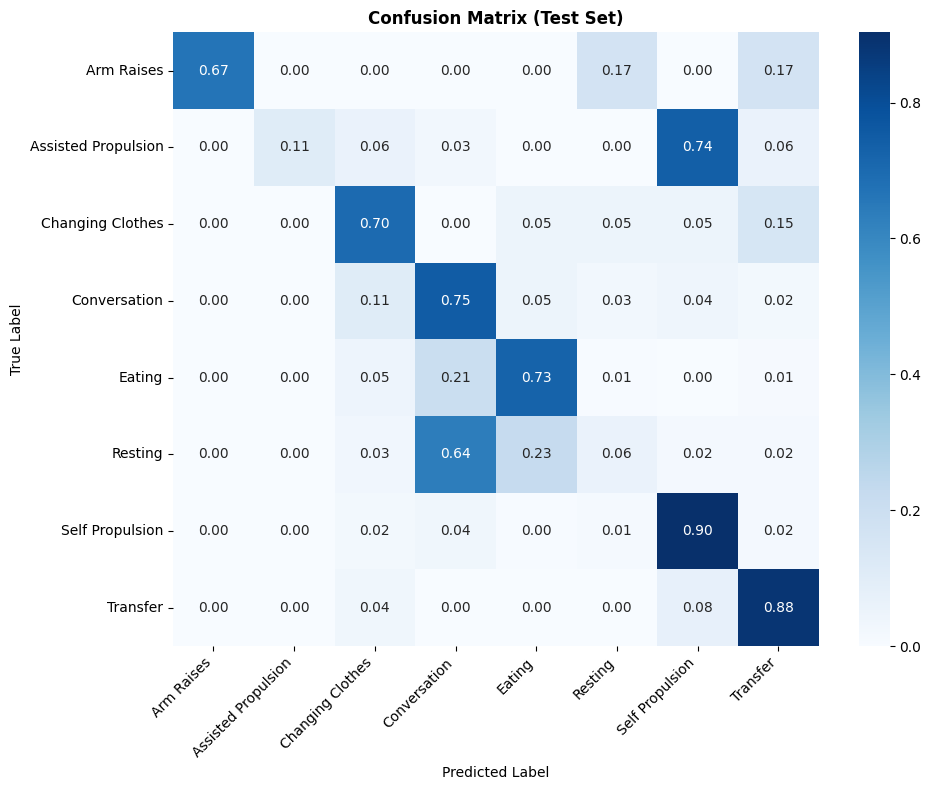

📊 Creating feature importance plot...
📊 Feature importance plot saved: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline/xgboost_feature_importance_top15.png
📊 Feature importance plot saved: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline/xgboost_feature_importance_top15.png


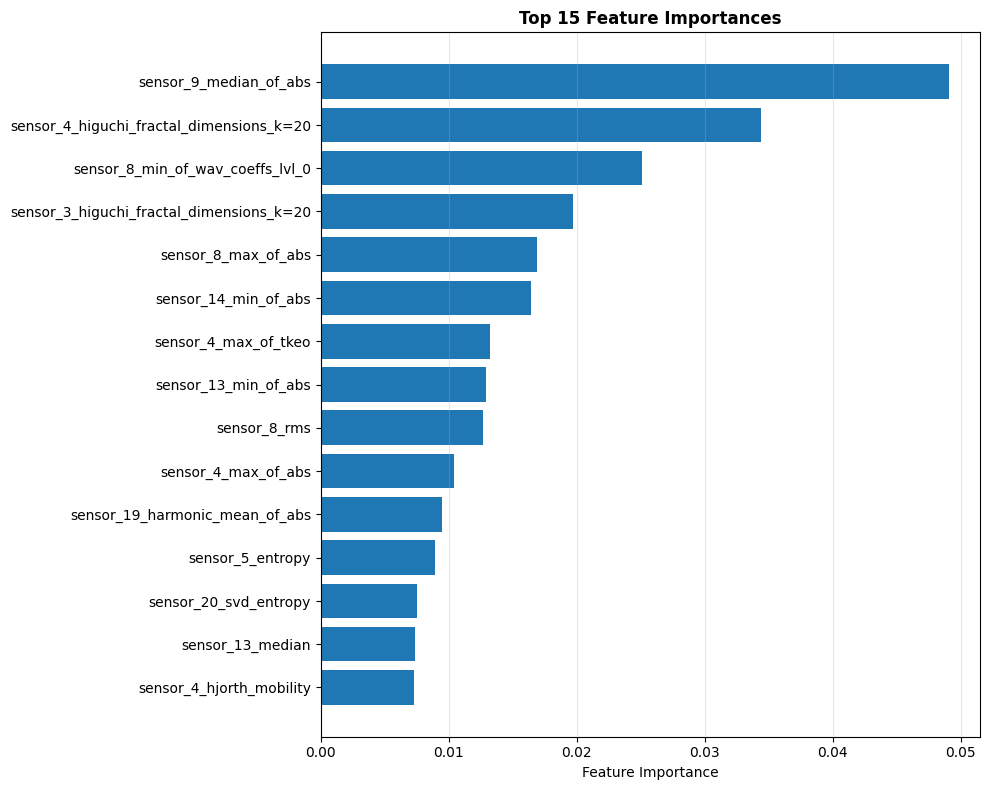

📊 Creating accuracy comparison...
📊 Accuracy comparison plot saved: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline/xgboost_accuracy_comparison.png
📊 Accuracy comparison plot saved: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline/xgboost_accuracy_comparison.png


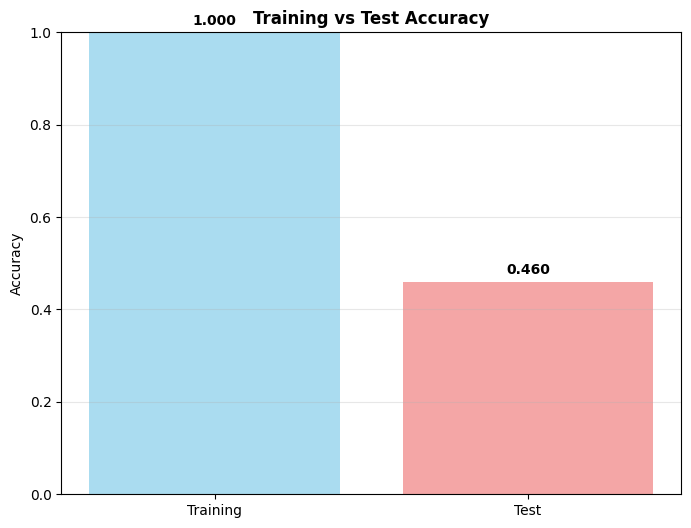

📊 Creating class distribution plot...
📊 Class distribution plot saved: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline/xgboost_class_distribution.png
📊 Class distribution plot saved: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline/xgboost_class_distribution.png


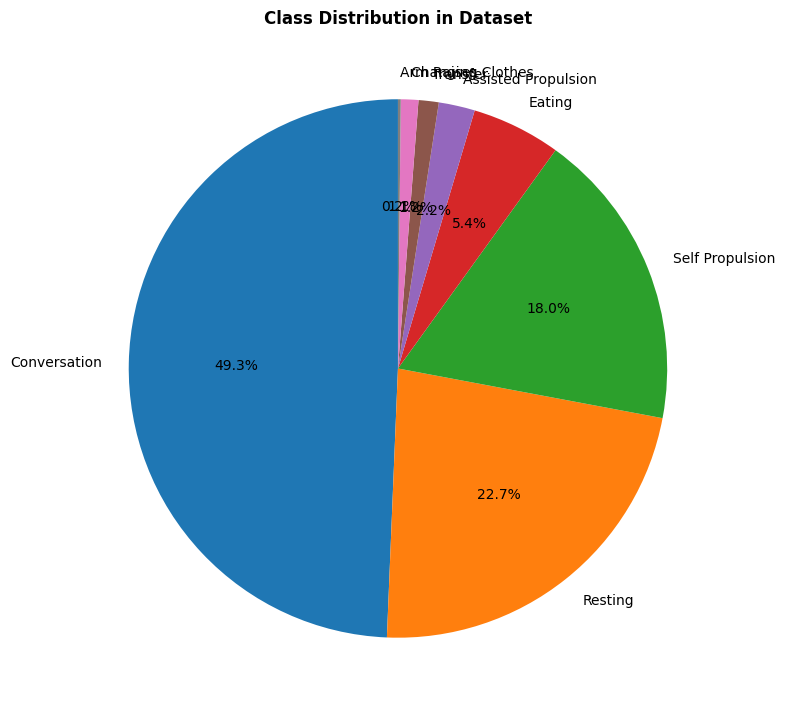


📊 Creating additional visualizations...
📊 Detailed feature importance saved: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline/detailed_feature_importance.png
📊 Detailed feature importance saved: /scai_data3/scratch/stirnimann_r/results/xgboost_pipeline/detailed_feature_importance.png


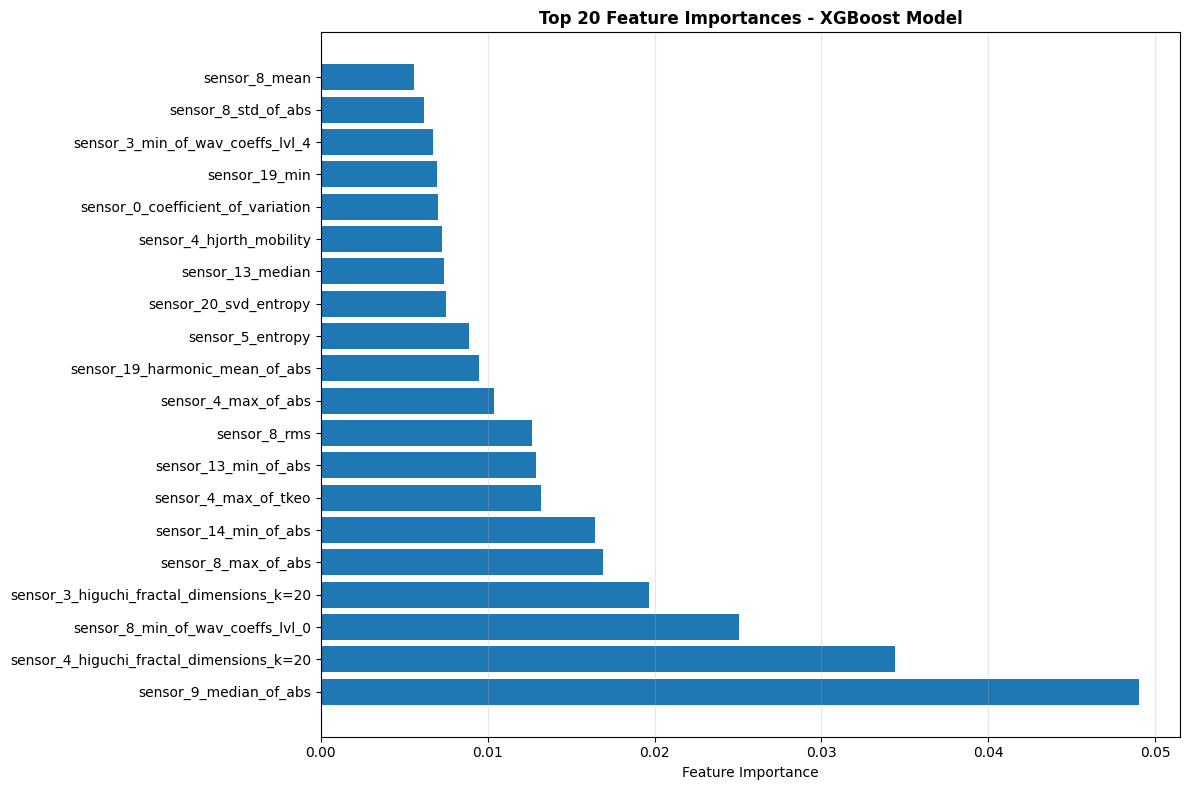


📊 FINAL SUMMARY
Dataset Statistics:
  Total windows: 15604
  Window size: 250 samples (10.0s)
  Features extracted: 1196
  Classes: 8

Model Performance:
  Training accuracy: 1.0000
  Test accuracy: 0.4599
  Generalization gap: 0.5401

Feature Categories (approximate):
  Statistical features: ~780
  Spectral features: ~26
  Time-frequency features: ~442
  Other features: ~-52


In [62]:
# Create visualizations for model results
if 'model' in locals() and model is not None:
    print(f"\n=== CREATING VISUALIZATIONS ===")
    
    # Set up the plotting style
    plt.style.use('default')
    
    # 1. Confusion Matrix Heatmap
    print(f"📊 Creating confusion matrix heatmap...")
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='.2f', 
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.title('Confusion Matrix (Test Set)', fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join(PIPELINE_RESULTS_DIR, 'xgboost_confusion_matrix.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📊 Confusion matrix saved: {plot_path}")
    plt.show()

    # 2. Feature Importance (Top 15)
    print(f"📊 Creating feature importance plot...")
    plt.figure(figsize=(10, 8))
    top_15_features = importance_df.head(15)
    plt.barh(top_15_features['feature'], top_15_features['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances', fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis() # To show most important at top
    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(PIPELINE_RESULTS_DIR, 'xgboost_feature_importance_top15.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📊 Feature importance plot saved: {plot_path}")
    plt.show()
    
    # 3. Training vs Test Accuracy
    print(f"📊 Creating accuracy comparison...")
    plt.figure(figsize=(8, 6))
    accuracies = [train_accuracy, test_accuracy]
    labels = ['Training', 'Test']
    colors = ['skyblue', 'lightcoral']
    
    bars = plt.bar(labels, accuracies, color=colors, alpha=0.7)
    plt.ylabel('Accuracy')
    plt.title('Training vs Test Accuracy', fontweight='bold')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Save the plot
    plot_path = os.path.join(PIPELINE_RESULTS_DIR, 'xgboost_accuracy_comparison.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📊 Accuracy comparison plot saved: {plot_path}")
    plt.show()

    # 4. Class Distribution
    print(f"📊 Creating class distribution plot...")
    plt.figure(figsize=(8, 8))
    class_counts = pd.Series(y).value_counts()
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Class Distribution in Dataset', fontweight='bold')
    plt.ylabel('') # Hide the 'None' ylabel
    plt.tight_layout()

    # Save the plot
    plot_path = os.path.join(PIPELINE_RESULTS_DIR, 'xgboost_class_distribution.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📊 Class distribution plot saved: {plot_path}")
    plt.show()
    
    # Additional detailed plots
    print(f"\n📊 Creating additional visualizations...")
    
    # Feature importance detailed plot
    plt.figure(figsize=(12, 8))
    top_20_features = importance_df.head(20)
    plt.barh(range(len(top_20_features)), top_20_features['importance'])
    plt.yticks(range(len(top_20_features)), top_20_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances - XGBoost Model', fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    # Save detailed feature importance plot
    detailed_plot_path = os.path.join(PIPELINE_RESULTS_DIR, 'detailed_feature_importance.png')
    plt.savefig(detailed_plot_path, dpi=300, bbox_inches='tight')
    print(f"📊 Detailed feature importance saved: {detailed_plot_path}")
    
    plt.show()
    
    # Summary statistics
    print(f"\n📊 FINAL SUMMARY")
    print(f"=" * 50)
    print(f"Dataset Statistics:")
    print(f"  Total windows: {len(combined_labels)}")
    print(f"  Window size: {WINDOW_SIZE} samples ({WINDOW_DURATION_SEC:.1f}s)")
    print(f"  Features extracted: {len(feature_names)}")  # Changed from matched_features to feature_names
    print(f"  Classes: {len(label_encoder.classes_)}")
    if 'subject_id' in combined_window_info.columns:
        print(f"  Total subjects: {combined_window_info['subject_id'].nunique()}")
    print(f"")
    print(f"Model Performance:")
    print(f"  Training accuracy: {train_accuracy:.4f}")
    print(f"  Test accuracy: {test_accuracy:.4f}")
    print(f"  Generalization gap: {train_accuracy - test_accuracy:.4f}")
    print(f"")
    print(f"Feature Categories (approximate):")
    statistical_count = len([f for f in feature_names if any(term in f.lower() for term in ['mean', 'std', 'var', 'skew', 'kurt', 'min', 'max', 'median'])])
    spectral_count = len([f for f in feature_names if any(term in f.lower() for term in ['spectral', 'freq', 'power', 'band'])])
    time_freq_count = len([f for f in feature_names if any(term in f.lower() for term in ['wav', 'tkeo', 'hjorth', 'entropy'])])
    other_count = len(feature_names) - statistical_count - spectral_count - time_freq_count

    print(f"  Statistical features: ~{statistical_count}")
    print(f"  Spectral features: ~{spectral_count}")
    print(f"  Time-frequency features: ~{time_freq_count}")
    print(f"  Other features: ~{other_count}")
    
else:
    print(f"❌ No model available for visualization!")